In [1]:
import pandas as pd
import numpy as np
import random
import time
import os
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

 #### Define a function to calculate distances to centroids for a given set of data points

In [36]:
def distance(points, centroids):
    distanceToCentroids = lambda point: \
        np.array([np.linalg.norm(point - centroid) for centroid in centroids],dtype = float)
    
    return(np.apply_along_axis(distanceToCentroids, 1, points))

#### Define the function to iteratively find the cluster centroids

In [3]:
def k_means(X, n_clusters, max_iter=300, tol=1e-4):
    # X : array-like matrix, already standardized
    
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    # initialize the centroids
    # random sampling, can use other methods like kmeans++
    centroids = X[random.sample(range(n_samples), n_clusters), ]
    
    # calculate the distances to clusters, clustering labels and the resulting inertia
    distances = distance(X, centroids)
    labels = np.argmin(distances, axis = 1)
    inertia = np.sum((X - centroids[labels])**2, dtype=np.float64)
    
    for iteration in range(max_iter):
        
        n_samples_in_cluster = np.bincount(labels, minlength = n_clusters)

        # calculate the new centroids by taking the means of data points in the same cluster
        # this can be customized with other approaches like KMedoids 
        centroids = np.zeros(shape = (n_clusters, n_features))
        for i in range(n_samples):
            for j in range(n_features):
                centroids[labels[i], j] += X[i, j]

        centroids /= n_samples_in_cluster[:, np.newaxis]
        distances = distance(X, centroids)
        labels = np.argmin(distances, axis = 1)
        inertia_previous = inertia
        inertia = np.sum((X - centroids[labels])**2, dtype=np.float64)

        if (np.linalg.norm(inertia - inertia_previous) < tol):
            break

    return(centroids, inertia, labels, iteration)

### Run kMeans on the sampled Milliman dataset

#### Load the dataset, remove categorical variables, impute missing values in numeric variables

In [56]:
os.chdir("/home/capsops/sha")
# Use a smaller data set to save time
df = pd.read_csv('PHBsample14_sss.csv', low_memory=False)
# drop the column resulted from sampling of the original data set
df.drop('Unnamed: 0', axis=1, inplace=True)
# In order to run K-means, drop all the categoricald data for now.
df = df.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df = df.fillna(df.mean())

In [57]:
t1 = time.time()
pca = PCA(2, svd_solver='randomized')
pca.fit(df)
df_reduced = pca.fit_transform(df)
df_reduced = StandardScaler().fit_transform(df_reduced)
t2 = time.time()
print("time to run PCA: ", t2 - t1)

time to run PCA:  5.249779462814331


#### Plot the sampled dataset in the reduced feature space

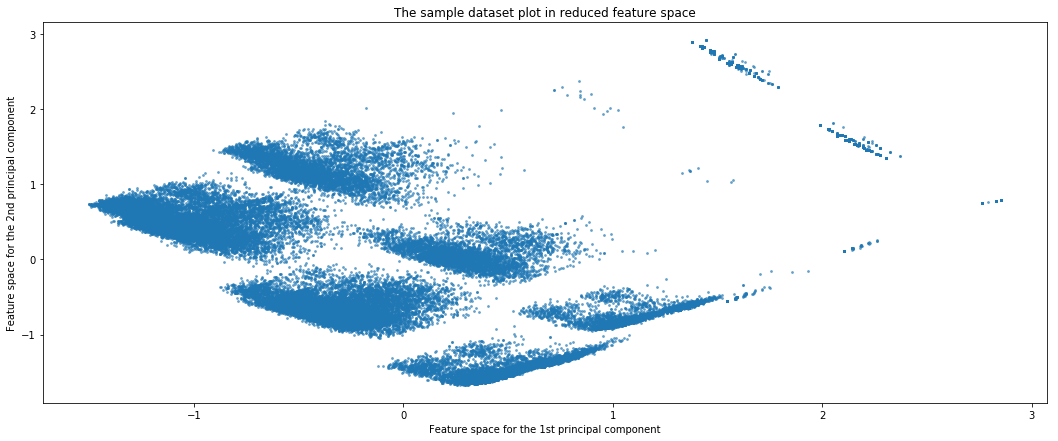

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax.scatter(df_reduced[:, 0], df_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            edgecolor='k')

ax.set_title("The sample dataset plot in reduced feature space")
ax.set_xlabel("Feature space for the 1st principal component")
ax.set_ylabel("Feature space for the 2nd principal component")
plt.show()

#### Standardize the data points before clustering

In [59]:
X = df_reduced
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [60]:
X_sc.shape

(59159, 2)

#### Run kMeans to cluster data

In [61]:
t1 = time.time()
centroids, inertia, labels, iteration = k_means(X_sc, 7)
t2 = time.time()

print("Time to cluster the data: ", t2-t1, "seconds")

Time to cluster the data:  47.52191996574402


### Calculate Silhouette scores

In [4]:
### Self-implemented algorithm, slow

# def silhouette_scores (X, labels):
#     n_samples = X.shape[0]
#     silhouettes = np.zeros(shape=(n_samples, )) 
    
#     # calculate the silhouette scores for each data point based on the new clusters
#     for i in range(n_samples):
#         a_i = np.average(np.ma.masked_equal(distance(X[labels == labels[i,], ], X[i:i+1,]),0))
#         b_i = np.min(distance(X[labels != labels[i,], ], X[i:i+1,]))
#         silhouettes[i,] = (b_i - a_i)/np.max([a_i, b_i])
#     return silhouettes

#### silhouette_sample_block approach

reference: https://gist.github.com/AlexandreAbraham/5544803#comments

In [24]:
from itertools import combinations
import numpy as np

from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import distance_metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.externals.joblib import Parallel, delayed

def silhouette_samples_block(X, labels, metric='euclidean', n_jobs=1, **kwds):
    """Compute the Silhouette Coefficient for each sample.
    The Silhoeutte Coefficient is a measure of how well samples are clustered
    with samples that are similar to themselves. Clustering models with a high
    Silhouette Coefficient are said to be dense, where samples in the same
    cluster are similar to each other, and well separated, where samples in
    different clusters are not very similar to each other.
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (a) and the mean nearest-cluster distance (b) for each sample.
    The Silhouette Coefficient for a sample is ``(b - a) / max(a, b)``.
    This function returns the Silhoeutte Coefficient for each sample.
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
             label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : array, shape = [n_samples]
        Silhouette Coefficient for each samples.
    References
    ----------
    Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
        Interpretation and Validation of Cluster Analysis". Computational
        and Applied Mathematics 20: 53-65. doi:10.1016/0377-0427(87)90125-7.
    http://en.wikipedia.org/wiki/Silhouette_(clustering)
    """
    A = _intra_cluster_distances_block(X, labels, metric, n_jobs=n_jobs,
                                       **kwds)
    B = _nearest_cluster_distance_block(X, labels, metric, n_jobs=n_jobs,
                                        **kwds)
    sil_samples = (B - A) / np.maximum(A, B)
    # nan values are for clusters of size 1, and should be 0
    return np.nan_to_num(sil_samples)


def _intra_cluster_distances_block_(subX, metric, **kwds):
    distances = pairwise_distances(subX, metric=metric, **kwds)
    return distances.sum(axis=1) / (distances.shape[0] - 1)


def _intra_cluster_distances_block(X, labels, metric, n_jobs=1, **kwds):
    """Calculate the mean intra-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    a : array [n_samples_a]
        Mean intra-cluster distance
    """
    intra_dist = np.zeros(labels.size, dtype=float)
    values = Parallel(n_jobs=n_jobs)(
            delayed(_intra_cluster_distances_block_)
                (X[np.where(labels == label)[0]], metric, **kwds)
                for label in np.unique(labels))
    for label, values_ in zip(np.unique(labels), values):
        intra_dist[np.where(labels == label)[0]] = values_
    return intra_dist


def _nearest_cluster_distance_block_(subX_a, subX_b, metric, **kwds):
    dist = pairwise_distances(subX_a, subX_b, metric=metric, **kwds)
    dist_a = dist.mean(axis=1)
    dist_b = dist.mean(axis=0)
    return dist_a, dist_b


def _nearest_cluster_distance_block(X, labels, metric, n_jobs=1, **kwds):
    """Calculate the mean nearest-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    X : array [n_samples_a, n_features]
        Feature array.
    Returns
    -------
    b : float
        Mean nearest-cluster distance for sample i
    """
    inter_dist = np.empty(labels.size, dtype=float)
    inter_dist.fill(np.inf)
    # Compute cluster distance between pairs of clusters
    unique_labels = np.unique(labels)

    values = Parallel(n_jobs=n_jobs)(
            delayed(_nearest_cluster_distance_block_)(
                X[np.where(labels == label_a)[0]],
                X[np.where(labels == label_b)[0]],
                metric, **kwds)
                for label_a, label_b in combinations(unique_labels, 2))

    for (label_a, label_b), (values_a, values_b) in \
            zip(combinations(unique_labels, 2), values):

            indices_a = np.where(labels == label_a)[0]
            inter_dist[indices_a] = np.minimum(values_a, inter_dist[indices_a])
            del indices_a
            indices_b = np.where(labels == label_b)[0]
            inter_dist[indices_b] = np.minimum(values_b, inter_dist[indices_b])
            del indices_b
    return inter_dist

In [63]:
t0 = time.time()
silhouettes = silhouette_samples_block(X_sc, labels, metric='euclidean', n_jobs=-1)
t = time.time() - t0

print ('Block silhouette parallel run time:', t, "seconds")

Block silhouette parallel run time: 16.84496545791626 seconds


### Compare model performance with Scikit-Learn kMeans

In [64]:
t1 = time.time()
kmeans = KMeans(n_clusters=7, random_state=0).fit(X_sc)
t2 = time.time()
print("Time to cluster the data: ", t2-t1, "seconds")

Time to cluster the data:  0.6812722682952881 seconds
